In [1]:
import collections

class PI:
    PI_list = collections.defaultdict()
    proj_list = collections.defaultdict(str)
    def __init__(self, **kwargs):
        self.name = kwargs.get('name', '')
        self.dept = kwargs.get('dept', [])
        self.proj = kwargs.get('proj', [])
        # updating proj_list
        PI.update_proj_list(self)
        
        # updating PI_list
        PI.update_PI_list(self)
        
    
    def __repr__(self):
        return 'PI: {} '.format(self.name) + ','.join(self.dept) + ' ' + ','.join(self.proj)
    
    def add_dept(self, s):
        self.dept.append(s)
        
    def add_proj(self, s):
        self.proj.append(s)
        
    def update_proj_list(self):
        for p in self.proj:               
            if p not in PI.proj_list.keys():
                PI.proj_list[p] = self.name
            else:
                pass
            
    def update_PI_list(self):
        if self.name not in PI.PI_list.keys():
            PI.PI_list[self.name] = self
        else:
            for p in self.proj:
                if p not in PI.PI_list[self.name].proj:
                    PI.PI_list[self.name].add_proj(p)
                else:
                    pass
            for dept in self.dept:
                if dept not in PI.PI_list[self.name].dept:
                    PI.PI_list[self.name].add_dept(dept)
                else:
                    pass
    
    @classmethod
    def get_PI_list(cls):
        return cls.PI_list
    
    @classmethod
    def get_proj_list(cls):
        return cls.proj_list

LuiSha = PI(name='Lui Sha',dept=['CS','CSL'],proj=['2016-08-100-02'])
RomitChoudhury = PI(name='Romit Roy Choudhury',dept=['ECE','CSL'],proj=['2017-06-100-01'])
SayanMitra = PI(name='Sayan Mitra',dept=['ECE','CSL'],proj=['2016-06-103-01'])
GirishKrishnan = PI(name='Girish Krishnan',dept=['ISE','CSL'],proj=['2017-03-106-01'])
SethHutchinson = PI(name='Seth Hutchinson', dept=['ECE', 'CSL'],proj=['2016-10-103-02', '2016-10-103-01'])
GraceGao = PI(name='Grace Gao', dept=['AE', 'CSL'], proj=['2016-11-103-01'])
MinhDo = PI(name='Minh Do', dept=['ECE', 'CSL'], proj=['2016-11-103-02'])
TimBretl = PI(name='Timothy Bretl', dept=['AE', 'CSL'], proj=['2017-02-103-02'])
MichaelSelig = PI(name='Michael Selig', dept=['AE'], proj=['2017-02-102-01'])
HwPark = PI(name='Hae-Won Park', dept=['ME', 'CSL'], proj=['2017-02-101-01'])
AimyWissa = PI(name='Aimy Wissa', dept=['ME'], proj=['2017-04-101-01'])
SayanMitra = PI(name='Sayan Mitra', dept=['ECE', 'CSL'], proj=['2017-03-103-01'])
PhilipAnsell = PI(name='Philip Ansell', dept=['AE'], proj=['2017-01-102-01'])
RomitRoyChoudhury = PI(name='Romit Roy Choudhury', dept=['ECE', 'CSL'], proj=['2016-08-100-01', '2017-02-100-01'])
GirishChowdhary = PI(name='Girish Chowdhary', dept=['ABE', 'CSL'], proj=['2016-11-105-01', '2016-10-105-01'])
AmyLaViers = PI(name='Amy LaViers', dept=['ME'], proj=['2016-12-101-01'])
NairaHovakimyan = PI(name='Naira Hovakimyan', dept=['ME','AE', 'CSL'], proj=['2016-08-101-01'])
PaulKwiat = PI(name='Paul G Kwiat', dept=['PHYS', 'ECE'], proj=['2016-08-104-01'])
DanWork = PI(name='Dan Work', dept=['CEE', 'CSL'], proj=['2017-06-107-01'])

In [2]:
print(PI.PI_list)

defaultdict(None, {'Lui Sha': PI: Lui Sha CS,CSL 2016-08-100-02, 'Romit Roy Choudhury': PI: Romit Roy Choudhury ECE,CSL 2017-06-100-01,2016-08-100-01,2017-02-100-01, 'Sayan Mitra': PI: Sayan Mitra ECE,CSL 2016-06-103-01,2017-03-103-01, 'Girish Krishnan': PI: Girish Krishnan ISE,CSL 2017-03-106-01, 'Seth Hutchinson': PI: Seth Hutchinson ECE,CSL 2016-10-103-02,2016-10-103-01, 'Grace Gao': PI: Grace Gao AE,CSL 2016-11-103-01, 'Minh Do': PI: Minh Do ECE,CSL 2016-11-103-02, 'Timothy Bretl': PI: Timothy Bretl AE,CSL 2017-02-103-02, 'Michael Selig': PI: Michael Selig AE 2017-02-102-01, 'Hae-Won Park': PI: Hae-Won Park ME,CSL 2017-02-101-01, 'Aimy Wissa': PI: Aimy Wissa ME 2017-04-101-01, 'Philip Ansell': PI: Philip Ansell AE 2017-01-102-01, 'Girish Chowdhary': PI: Girish Chowdhary ABE,CSL 2016-11-105-01,2016-10-105-01, 'Amy LaViers': PI: Amy LaViers ME 2016-12-101-01, 'Naira Hovakimyan': PI: Naira Hovakimyan ME,AE,CSL 2016-08-101-01, 'Paul G Kwiat': PI: Paul G Kwiat PHYS,ECE 2016-08-104-01, '

In [20]:
import datetime, dateutil.parser, calendar
from dateutil.relativedelta import relativedelta
from oauth2client import client
from googleapiclient import sample_tools

def crawl(start_date = datetime.date(2017,1,1), end_date = datetime.date.today() ):
    # Authenticate and construct service.
    service, flags = sample_tools.init(
        ' ', 'calendar', 'v3', ' ', ' ',
        scope='https://www.googleapis.com/auth/calendar.readonly')
    page_token = None
    
    proj = {}
    while True:
        events = service.events().list(calendarId='irl1.uiuc@gmail.com', pageToken=page_token).execute()
        for event in events['items']:
            if 'start' in event.keys():
                e_date_str = event['start']['dateTime']
                e_date_str = e_date_str.split('T')[0].split('-')

                e_date = datetime.date(int(e_date_str[0]), int(e_date_str[1]), int(e_date_str[2]))
                                   
                if e_date >= start_date and e_date < end_date:
                    items = event.items()
                    for key, value in items:
                        if key == 'description':
                            pieces = value.split('PROJ:')
                            pieces = pieces[-1].split('\n')
                            num = pieces[0].strip()
                            if num[:3] == '201': # 2016, 2017, 201x
                                deltaTime = dateutil.parser.parse(event['end']['dateTime']) - dateutil.parser.parse(event['start']['dateTime'])
                                time_h = deltaTime.seconds/3600
                                if num in proj.keys():
                                    
                                    proj[num] += time_h
                                else:
                                    proj[num] = time_h
                    
        page_token = events.get('nextPageToken')
        if not page_token:
            break
            
    return proj

def fetch_month(year, month):
    start_date = datetime.date(year,month,1)
    end_date = start_date + relativedelta(months = +1)
    fetch = crawl(start_date, end_date)
    return fetch

def get_hours(fetch, proj_number_PI_mapping):
    PI_hours = {}
    dept_hours = {}
    
    for key, value in fetch.items():
        if key not in proj_number_PI_mapping.keys():
            raise RuntimeError("unknown project number from PI database, key = {}".format(key))
        
        name = proj_number_PI_mapping[key]
    
        if name not in PI_hours.keys():
            PI_hours[name] = value
        else:
            PI_hours[name] += value
    
        d = PIs[name].dept
    
        for i in d:
            if i not in dept_hours.keys():
                dept_hours[i] = value
            else:
                dept_hours[i] += value

    return PI_hours, dept_hours

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def get_monthly_report(year, month, proj_number_PI_mapping, PI_list):

    title = '-'.join([str(year), str(month)])

    writer = pd.ExcelWriter('.'.join([title, 'xlsx']))

    pi_hours, dept_hours = get_hours(fetch_month(year, month), proj_number_PI_mapping)

    pi_data = pd.DataFrame(list(pi_hours.items()))
    pi_data.columns = ['name', 'hours']
    pi_data = pi_data.sort_values('hours', ascending=False)
    pi_data.reset_index(drop=True, inplace=True)

    dept_list = []
    for index, row in pi_data.iterrows():
        key = row['name']
        dept = PI_list[key].dept
        dept_list.append(dept)

    pi_data['dept'] = pd.Series(dept_list)

    dept_data = pd.DataFrame(list(dept_hours.items()))
    dept_data.columns = ['dept', 'hours']
    dept_data = dept_data.sort_values('hours', ascending=False)
    dept_data.reset_index(drop=True, inplace=True)

    # write to excel files
    pi_data.to_excel(writer, 'PI hours')
    dept_data.to_excel(writer, 'dept hours')
    writer.save()

    # calculating utilization
    days = calendar.monthrange(year, month)[1]
    total_hours = 8.0 * days
    used_hours = pi_data['hours'].sum()
    utilization_rate = used_hours / total_hours * 100
    
    suptitle = ','.join([title, '(utilization rate = {:.{prec}f} %)'.format(utilization_rate, prec=1)])
    plt.suptitle(suptitle, y=1.0)
    sns.set_style("darkgrid")
    plt.subplot(1,2,1)

    pi_plot = sns.barplot(x= pi_data['name'], y=pi_data['hours'], palette="muted")
    xlabels = []
    for index, row in pi_data.iterrows():
        xlabel = row['name'] + '\n' + '(' + ','.join(row['dept']) + ')'
        xlabels.append(xlabel)
    pi_plot.set(xticklabels=xlabels)

    plt.xticks(rotation=90)

    plt.subplot(1,2,2)
    dept_plot = sns.barplot(x=dept_data['dept'], y=dept_data['hours'], palette="muted")    
    
    #left, right, top, bottom = plt.axis()
    #plt.axis((left, right, top+0.5, bottom))
    plt.tight_layout()
    plt.savefig('.'.join([title, 'jpg']))

In [21]:
%matplotlib notebook

<IPython.core.display.Javascript object>


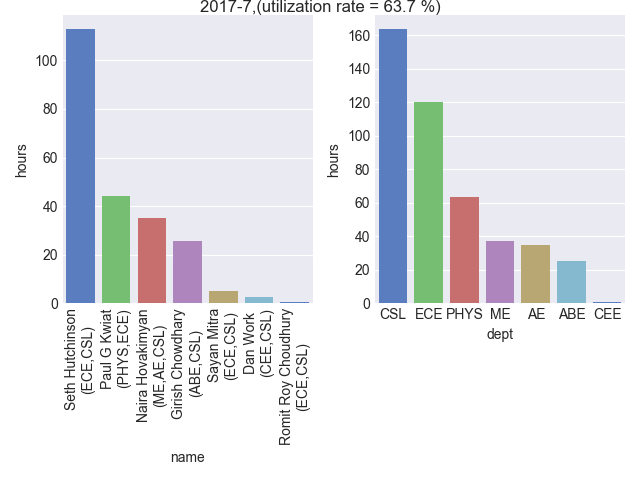

In [22]:
proj_number = PI.get_proj_list()
PIs = PI.get_PI_list()

for i in range(6,13):
    get_monthly_report(2016,i,proj_number, PIs)

for i in range(1,8):
    get_monthly_report(2017,i,proj_number, PIs)